#### 기본 코드

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Classification Model 정의 (Discriminator 구조 기반)
class Classifier(nn.Module):
    def __init__(self, img_channels=1, feature_d=64, num=10):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, feature_d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(feature_d)
        self.r1 = nn.LeakyReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(feature_d, feature_d*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(feature_d*4)
        self.r2 = nn.ReLU(inplace=True)
        
        self.conv3 = nn.Conv2d(feature_d*4, num, kernel_size=3, stride=2, padding=0, bias=False)
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.r1(self.bn1(self.conv1(x)))
        x = self.r2(self.bn2(self.conv2(x)))
        x = self.conv3(x)
        x = self.flatten(x) 
        return x 

batch_size = 64
lr = 0.0001
epochs = 100
device = "mps"

# Transform 정의
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # MNIST 이미지 크기 유지
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST 데이터셋 로드
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"test : {len(test_loader)}, train :{len(train_loader)}")

# 모델 초기화 및 Optimizer 설정
model = Classifier(img_channels=1, feature_d=32).to(device)
loss_fun = nn.CrossEntropyLoss()  # CrossEntropyLoss는 Softmax를 포함하므로 별도 적용 필요 없음
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training Loop
loss_train = []
loss_test = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        outputs = model(images)
        
        loss = loss_fun(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    loss_train.append(avg_train_loss)
   
    model.eval()
    running_test_loss = 0.0  
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fun(outputs, labels)
            running_test_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item() 
            
    avg_test_loss = running_test_loss / len(test_loader)
    loss_test.append(avg_test_loss)

    test_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

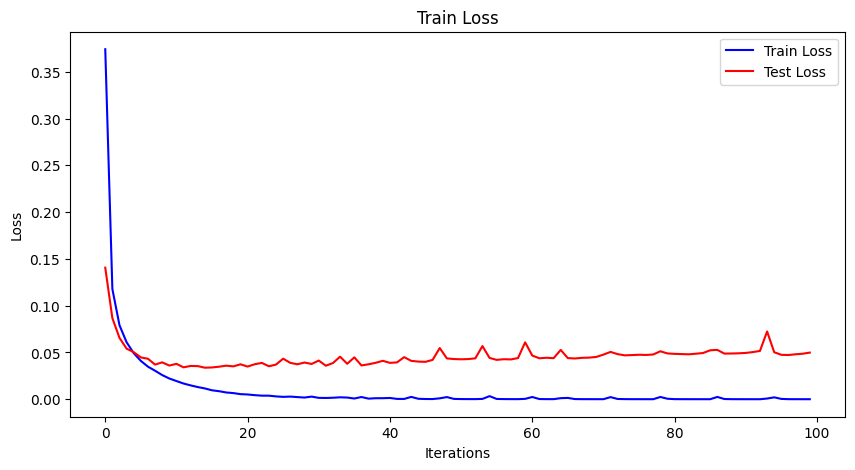

In [130]:
import matplotlib.pyplot as plt

# 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(loss_train, label="Train Loss", color='blue')
plt.plot(loss_test, label="Test Loss", color='red')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Train Loss")
plt.legend() 
plt.show()

In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

class Classifier_Conv6_FC_Dropout(nn.Module):
    def __init__(self, img_channels=1, feature_d=64, num_classes=10, dropout_rate=0.4):
        super(Classifier_Conv6_FC_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, feature_d, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(feature_d)
        self.r1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(feature_d, feature_d * 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(feature_d * 2)
        self.r2 = nn.LeakyReLU(inplace=True)

        self.conv3 = nn.Conv2d(feature_d * 2, feature_d * 4, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(feature_d * 4)
        self.r3 = nn.LeakyReLU(inplace=True)
        self.drop3 = nn.Dropout(dropout_rate)  

        self.conv4 = nn.Conv2d(feature_d * 4, feature_d * 8, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(feature_d * 8)
        self.r4 = nn.LeakyReLU(inplace=True)

        self.conv5 = nn.Conv2d(feature_d * 8, feature_d * 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(feature_d * 16)
        self.r5 = nn.LeakyReLU(inplace=True)
        self.drop5 = nn.Dropout(dropout_rate)  

        self.conv6 = nn.Conv2d(feature_d * 16, feature_d * 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(feature_d * 32)
        self.r6 = nn.LeakyReLU(inplace=True)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(feature_d * 32, 128) 
        self.r_fc1 = nn.LeakyReLU(inplace=True)
        self.drop_fc1 = nn.Dropout(dropout_rate)  

        self.fc2 = nn.Linear(128, num_classes)  

    def forward(self, x):
        x = self.r1(self.bn1(self.conv1(x)))
        x = self.r2(self.bn2(self.conv2(x)))
        x = self.r3(self.bn3(self.conv3(x)))
        x = self.drop3(x)  # 🔹 Dropout 적용
        x = self.r4(self.bn4(self.conv4(x)))
        x = self.r5(self.bn5(self.conv5(x)))
        x = self.drop5(x)  # 🔹 Dropout 적용
        x = self.r6(self.bn6(self.conv6(x)))

        x = self.flatten(x)  # 🔹 Fully Connected 입력 준비
        x = self.r_fc1(self.fc1(x))  
        x = self.drop_fc1(x)  # 🔹 FC Dropout 적용
        x = self.fc2(x)  # 🔹 최종 출력
        return x  # [B, num_classes]

batch_size = 64
lr = 0.0005
epochs = 20
device = "mps"

# Transform 정의
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # MNIST 이미지 크기 유지
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST 데이터셋 로드
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"test : {len(test_loader)}, train : {len(train_loader)}")

# 모델 초기화 및 Optimizer 설정
model = Classifier_ConvOnly(img_channels=1, feature_d=32).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training Loop
loss_train = []
loss_test = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Loss 계산
        loss = criterion(outputs, labels)
        
        # Backward pass 및 Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    loss_train.append(avg_train_loss)

    # Evaluation Loop
    model.eval()
    running_test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
    
    avg_test_loss = running_test_loss / len(test_loader)
    loss_test.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


test : 157, train : 938
Epoch [1/20], Train Loss: 0.1108, Test Loss: 0.0412
Epoch [2/20], Train Loss: 0.0378, Test Loss: 0.0417
Epoch [3/20], Train Loss: 0.0284, Test Loss: 0.0268
Epoch [4/20], Train Loss: 0.0205, Test Loss: 0.0242
Epoch [5/20], Train Loss: 0.0179, Test Loss: 0.0369
Epoch [6/20], Train Loss: 0.0124, Test Loss: 0.0360
Epoch [7/20], Train Loss: 0.0119, Test Loss: 0.0315
Epoch [8/20], Train Loss: 0.0098, Test Loss: 0.0264
Epoch [9/20], Train Loss: 0.0090, Test Loss: 0.0279
Epoch [10/20], Train Loss: 0.0069, Test Loss: 0.0305
Epoch [11/20], Train Loss: 0.0073, Test Loss: 0.0265
Epoch [12/20], Train Loss: 0.0063, Test Loss: 0.0352
Epoch [13/20], Train Loss: 0.0058, Test Loss: 0.0371
Epoch [14/20], Train Loss: 0.0056, Test Loss: 0.0276
Epoch [15/20], Train Loss: 0.0040, Test Loss: 0.0316
Epoch [16/20], Train Loss: 0.0040, Test Loss: 0.0368
Epoch [17/20], Train Loss: 0.0045, Test Loss: 0.0361
Epoch [18/20], Train Loss: 0.0042, Test Loss: 0.0320
Epoch [19/20], Train Loss: 0.00

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Conv 레이어만 추가된 Classifier
class Classifier_ConvOnly(nn.Module):
    def __init__(self, img_channels=1, feature_d=64, num_classes=10):
        super(Classifier_ConvOnly, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, feature_d, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(feature_d)
        self.r1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(feature_d, feature_d * 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(feature_d * 2)
        self.r2 = nn.LeakyReLU(inplace=True)

        self.conv3 = nn.Conv2d(feature_d * 2, feature_d * 4, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(feature_d * 4)
        self.r3 = nn.LeakyReLU(inplace=True)

        self.conv4 = nn.Conv2d(feature_d * 4, num_classes, kernel_size=3, stride=2, padding=1, bias=False)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.r1(self.bn1(self.conv1(x)))
        x = self.r2(self.bn2(self.conv2(x)))
        x = self.r3(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        x = self.flatten(x)
        return x  # [B, num_classes]
batch_size = 64
lr = 0.0001
epochs = 20
device = "mps"

# Transform 정의
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # MNIST 이미지 크기 유지
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST 데이터셋 로드
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"test : {len(test_loader)}, train :{len(train_loader)}")

# 모델 초기화 및 Optimizer 설정
model = Classifier(img_channels=1, feature_d=32).to(device)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss는 Softmax를 포함하므로 별도 적용 필요 없음
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training Loop
loss_train = []
loss_test = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Loss 계산
        loss = criterion(outputs, labels)
        
        # Backward pass 및 Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    loss_train.append(avg_train_loss)
    # print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Evaluation Loop
    model.eval()
    running_test_loss = 0.0  # 테스트 손실 누적 변수

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
    
    avg_test_loss = running_test_loss / len(test_loader)
    loss_test.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")



test : 157, train :938
Epoch [1/20], Train Loss: 0.3961, Test Loss: 0.1558
Epoch [2/20], Train Loss: 0.1242, Test Loss: 0.0899
Epoch [3/20], Train Loss: 0.0823, Test Loss: 0.0712
Epoch [4/20], Train Loss: 0.0640, Test Loss: 0.0579
Epoch [5/20], Train Loss: 0.0520, Test Loss: 0.0491
Epoch [6/20], Train Loss: 0.0435, Test Loss: 0.0456
Epoch [7/20], Train Loss: 0.0372, Test Loss: 0.0430
Epoch [8/20], Train Loss: 0.0321, Test Loss: 0.0414
Epoch [9/20], Train Loss: 0.0283, Test Loss: 0.0397
Epoch [10/20], Train Loss: 0.0247, Test Loss: 0.0390
Epoch [11/20], Train Loss: 0.0217, Test Loss: 0.0372
Epoch [12/20], Train Loss: 0.0190, Test Loss: 0.0362
Epoch [13/20], Train Loss: 0.0168, Test Loss: 0.0390
Epoch [14/20], Train Loss: 0.0150, Test Loss: 0.0347
Epoch [15/20], Train Loss: 0.0130, Test Loss: 0.0342
Epoch [16/20], Train Loss: 0.0111, Test Loss: 0.0373
Epoch [17/20], Train Loss: 0.0101, Test Loss: 0.0381
Epoch [18/20], Train Loss: 0.0090, Test Loss: 0.0344
Epoch [19/20], Train Loss: 0.007

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch.nn.functional as F

# Classification Model 정의 (FC Layer 추가)
class Classifier(nn.Module):
    def __init__(self, img_channels=1, feature_d=64, num_classes=10):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, feature_d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(feature_d)
        self.r1 = nn.LeakyReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(feature_d, feature_d * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(feature_d * 4)
        self.r2 = nn.ReLU(inplace=True)
        
        self.conv3 = nn.Conv2d(feature_d * 4, feature_d * 8, kernel_size=3, stride=2, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(feature_d * 8)
        self.r3 = nn.ReLU(inplace=True)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(feature_d * 8, 128)  # FC Layer 추가
        self.fc2 = nn.Linear(128, num_classes)  # 최종 출력층

    def forward(self, x):
        x = self.r1(self.bn1(self.conv1(x)))
        x = self.r2(self.bn2(self.conv2(x)))
        x = self.r3(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))  # 활성화 함수 적용
        x = self.fc2(x)
        return x  # [B, num_classes] 형태 출력

batch_size = 64
lr = 0.0001
epochs = 20
device = "mps"

# Transform 정의
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # MNIST 이미지 크기 유지
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST 데이터셋 로드
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"test : {len(test_loader)}, train : {len(train_loader)}")

# 모델 초기화 및 Optimizer 설정
model = Classifier(img_channels=1, feature_d=32).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training Loop
loss_train = []
loss_test = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Loss 계산
        loss = criterion(outputs, labels)
        
        # Backward pass 및 Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    loss_train.append(avg_train_loss)
    
    # Evaluation Loop
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
    
    avg_test_loss = running_test_loss / len(test_loader)
    loss_test.append(avg_test_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


test : 157, train : 938
Epoch [1/20], Train Loss: 0.3275, Test Loss: 0.0805
Epoch [2/20], Train Loss: 0.0689, Test Loss: 0.0553
Epoch [3/20], Train Loss: 0.0453, Test Loss: 0.0464
Epoch [4/20], Train Loss: 0.0317, Test Loss: 0.0528
Epoch [5/20], Train Loss: 0.0237, Test Loss: 0.0469
Epoch [6/20], Train Loss: 0.0190, Test Loss: 0.0405
Epoch [7/20], Train Loss: 0.0149, Test Loss: 0.0466
Epoch [8/20], Train Loss: 0.0140, Test Loss: 0.0394
Epoch [9/20], Train Loss: 0.0103, Test Loss: 0.0460
Epoch [10/20], Train Loss: 0.0107, Test Loss: 0.0470
Epoch [11/20], Train Loss: 0.0077, Test Loss: 0.0448
Epoch [12/20], Train Loss: 0.0071, Test Loss: 0.0455
Epoch [13/20], Train Loss: 0.0077, Test Loss: 0.0466
Epoch [14/20], Train Loss: 0.0063, Test Loss: 0.0434
Epoch [15/20], Train Loss: 0.0058, Test Loss: 0.0507
Epoch [16/20], Train Loss: 0.0066, Test Loss: 0.0435
Epoch [17/20], Train Loss: 0.0055, Test Loss: 0.0432
Epoch [18/20], Train Loss: 0.0045, Test Loss: 0.0413
Epoch [19/20], Train Loss: 0.00

In [ ]:
# Conv + Fully Connected Layer 추가된 Classifier
class Classifier_ConvFC(nn.Module):
    def __init__(self, img_channels=1, feature_d=64, num_classes=10):
        super(Classifier_ConvFC, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, feature_d, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(feature_d)
        self.r1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(feature_d, feature_d * 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(feature_d * 2)
        self.r2 = nn.LeakyReLU(inplace=True)

        self.conv3 = nn.Conv2d(feature_d * 2, feature_d * 4, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(feature_d * 4)
        self.r3 = nn.LeakyReLU(inplace=True)

        self.conv4 = nn.Conv2d(feature_d * 4, feature_d * 8, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(feature_d * 8)
        self.r4 = nn.LeakyReLU(inplace=True)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(feature_d * 8 * 2 * 2, 128)  # Hidden Layer 추가
        self.fc2 = nn.Linear(128, num_classes)  # Output Layer

    def forward(self, x):
        x = self.r1(self.bn1(self.conv1(x)))
        x = self.r2(self.bn2(self.conv2(x)))
        x = self.r3(self.bn3(self.conv3(x)))
        x = self.r4(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x  # [B, num_classes]


batch_size = 64
lr = 0.001
epochs = 20
device = "mps"

# Transform 정의
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # MNIST 이미지 크기 유지
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST 데이터셋 로드
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"test : {len(test_loader)}, train : {len(train_loader)}")

# 모델 초기화 및 Optimizer 설정
model = Classifier(img_channels=1, feature_d=32).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training Loop
loss_train = []
loss_test = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Loss 계산
        loss = criterion(outputs, labels)
        
        # Backward pass 및 Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    loss_train.append(avg_train_loss)
    
    # Evaluation Loop
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
    
    avg_test_loss = running_test_loss / len(test_loader)
    loss_test.append(avg_test_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


test : 157, train : 938
Epoch [1/20], Train Loss: 0.1404, Test Loss: 0.0591
Epoch [2/20], Train Loss: 0.0593, Test Loss: 0.0477
Epoch [3/20], Train Loss: 0.0430, Test Loss: 0.0343
Epoch [4/20], Train Loss: 0.0335, Test Loss: 0.0407
Epoch [5/20], Train Loss: 0.0281, Test Loss: 0.0379
Epoch [6/20], Train Loss: 0.0225, Test Loss: 0.0486
Epoch [7/20], Train Loss: 0.0208, Test Loss: 0.0369
Epoch [8/20], Train Loss: 0.0166, Test Loss: 0.0561
Epoch [9/20], Train Loss: 0.0169, Test Loss: 0.0390
Epoch [10/20], Train Loss: 0.0144, Test Loss: 0.0364
Epoch [11/20], Train Loss: 0.0135, Test Loss: 0.0410
Epoch [12/20], Train Loss: 0.0128, Test Loss: 0.0412
Epoch [13/20], Train Loss: 0.0120, Test Loss: 0.0375
Epoch [14/20], Train Loss: 0.0106, Test Loss: 0.0418
Epoch [15/20], Train Loss: 0.0084, Test Loss: 0.0367
Epoch [16/20], Train Loss: 0.0087, Test Loss: 0.0442
Epoch [17/20], Train Loss: 0.0091, Test Loss: 0.0544
Epoch [18/20], Train Loss: 0.0091, Test Loss: 0.0372
Epoch [19/20], Train Loss: 0.00

In [115]:
print(sum(loss_test) / epoch)

0.0522512743662259


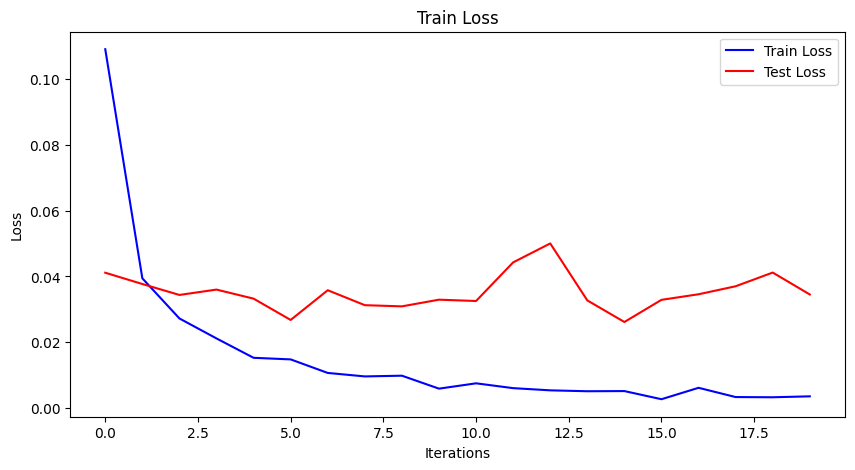

In [109]:
import matplotlib.pyplot as plt

# 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(loss_train, label="Train Loss", color='blue')
plt.plot(loss_test, label="Test Loss", color='red')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Train Loss")
plt.legend() 
plt.show()

# # 손실 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(loss_test, label="Test Loss", color='red')
# plt.xlabel("Iterations")
# plt.ylabel("Loss")
# plt.title("Test Loss")
# plt.legend() 
# plt.show()

In [116]:
import torch

# 저장된 모델 불러오기
model = Classifier(img_channels=1, feature_d=32).to(device)  # 모델 초기화
model.load_state_dict(torch.load("best_model.pth"))  # 저장된 가중치 불러오기
model.eval()  # 모델을 평가 모드로 설정

# 모델 정확도 평가 함수
def evaluate_accuracy(model, dataloader, device):
    model.eval()  # 평가 모드로 전환
    correct = 0
    total = 0

    with torch.no_grad():  # 그래디언트 계산 비활성화 (메모리 절약)
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # 가장 높은 점수를 가진 클래스 선택

            total += labels.size(0)  # 전체 샘플 개수
            correct += (predicted == labels).sum().item()  # 맞춘 개수

    accuracy = 100 * correct / total
    return accuracy

# 저장된 모델을 사용하여 테스트 데이터셋 전체 정확도 평가
test_accuracy = evaluate_accuracy(model, test_loader, device)
print(f"Test Accuracy of Best Model: {test_accuracy:.2f}%")


Test Accuracy: 98.74%
